# Heads-Up

In the notebook, we are working on generating
graphs whose nodes have Euclidean coordinates;
One thing to pay attention to is, in real world
road network, nodes (intersections) that are close
to each other geographically are more likely to be
connected with edges (roads).

Edge centrality will be added as part of the heuristic;
meantime, cosine distance can also be a good heuristic;
The geographical coordinates of nodes can be included.

# Questions

Does centrality really encode information about your destination?

# Think with Analogy

The model should not look back, only forward;
The graph used for training is small and
the trained model is used to infer nodes on
similar sized graphs; perhaps training with
big graphs will lead to better inference
on smaller graphs

# Thoughts

The model does not work very well on larger graph.
One direction to inspect is, does it really make sense
to use Dijkstra path as ground truth when the model
is fed with more meaningful features such as geo-locations
and cos-distances. Perhaps A* is a better algorithm to be 
used to provide the "ground truth"

When the graph grows larger, the size of the network should
grow accordingly so it has enough volume and power to learn
the graph.

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import mxnet as mx
import logging
from sklearn.metrics import accuracy_score
from utils import plot_g

In [ ]:
NUM_NODE = 100
WEIGHT_MIN = .5
WEIGHT_MAX = 1.

In [ ]:
def calc_euclidean_dist(G, tmp_node, node):
    
    p_1 = np.array([G.nodes[tmp_node]['x'], G.nodes[tmp_node]['y']])
    p_2 = np.array([G.nodes[node]['x'], G.nodes[node]['y']])
    return np.sqrt(np.sum((p_1 - p_2)**2))

def generate_low_degree_g(node_size=100, min_out_degree=2, max_out_degree=4, weight_min=WEIGHT_MIN, weight_max=WEIGHT_MAX):
    
    G = nx.Graph()
    
    grid_size = 1000
    euclidean_coords = np.linspace(0.01, 1.0, num=grid_size, endpoint=False)
    coords_indices = list(range(grid_size))
    
    random.shuffle(coords_indices)
    x_coords = euclidean_coords[coords_indices][:node_size]
#     print(x_coords)
    random.shuffle(coords_indices)
    y_coords = euclidean_coords[coords_indices][:node_size]
#     print(y_coords)
    
    # Add coordinates to nodes
    for node, coord in enumerate(zip(x_coords, y_coords)):
#         print(node, coord[0], coord[1])
        G.add_node(node, x=coord[0], y=coord[1])
    
    for node in G.nodes:
        
        tmp_nodes = list(G.nodes)
        tmp_nodes.remove(node)
        node_dist = map(lambda tmp_node: (tmp_node, calc_euclidean_dist(G, tmp_node, node)), tmp_nodes)
        node_dist = sorted(node_dist, key=lambda d:d[1])
        
        num_of_neighbors = random.randint(min_out_degree, max_out_degree)
#         print(node, out_neighbors)
        
#         G.add_edges_from(map(lambda d:(node, d), out_neighbors))
        
        for tmp_node in node_dist:

            if G.degree(tmp_node[0]) >= max_out_degree \
                or G.degree(node) >= num_of_neighbors:
                # This node has maximum number of neighbors already
                continue
            
            weight = random.uniform(weight_min, weight_max)
            geo_dist = calc_euclidean_dist(G, tmp_node[0], node)
            
            G.add_edge(node, tmp_node[0], weight=weight * geo_dist)
    
    # Add centrality to edges
    edge_centrality = nx.edge_betweenness_centrality(G, \
                                                     k=G.number_of_nodes(), \
                                                     weight='weight')
    assert len(edge_centrality) == G.number_of_edges()
    
    for edge_data in G.edges.data():
        edge_data[2]['centrality'] = edge_centrality[(edge_data[0], edge_data[1])]
        
    return G

In [ ]:
G = generate_low_degree_g(node_size=50)
max_degree = max(G.degree, key=lambda d: d[1])[1]
min_degree = min(G.degree, key=lambda d: d[1])[1]
print(max_degree)
print(min_degree)
print(G.number_of_nodes())
print(G.number_of_edges())
plot_g(G)

In [ ]:
def calc_cosine_dist(p1, p2):
    return np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2))

def encode_edges(G, parent, node, dst):
    
    ret = np.zeros((max_degree, 7))
    ret[:, -1] = -1
    
    x_dst = G.nodes[dst]['x']
    y_dst = G.nodes[dst]['y']
    
    for idx, edge in enumerate(G.edges(node)):
        u = edge[0]
        v = edge[1]
        
#         Only look forward
        if v == parent:
            continue
        
        ret[idx][0] = G.get_edge_data(u, v)['centrality']
        ret[idx][1] = G.get_edge_data(u, v)['weight']
        
        x_u = G.nodes[u]['x']
        y_u = G.nodes[u]['y']
        x_v = G.nodes[v]['x']
        y_v = G.nodes[v]['y']

        ret[idx][2] = calc_cosine_dist((x_v-x_u, y_v-y_u), (x_dst-x_u, y_dst-y_u))
        ret[idx][3] = calc_euclidean_dist(G, v, dst)
        ret[idx][4] = x_v
        ret[idx][5] = y_v
        ret[idx][-1] = v
        
    return (ret, x_dst, y_dst)

def generate_dataset(G):
    
    X = []
    y = []

    for paths in nx.all_pairs_dijkstra_path(G):

        print("src :%d" % paths[0])
        print(paths[1])
        print('')
        src = paths[0]

        for dst, path in paths[1].items():

            if dst == src:
                continue

            # X = cur_node + dst_node
            # y = next_node (Dijkstra)
            parent_node = -1
            cur_node = src
            for mid_node in path[1:]:

                print('parent:(%d), X:(%d, %d), y:(%d)' % (parent_node, cur_node, dst, mid_node))
                X.append(encode_edges(G, parent_node, cur_node, dst))
                y.append(mid_node)
                
                parent_node = cur_node
                cur_node = mid_node

    #         print(cur_node, dst)
            print(path)
            print('')
    
    return X, y

In [ ]:
features, labels = generate_dataset(G)

In [ ]:
len(labels)

In [ ]:
def find_label_idx(feature, label):
    
    for idx, row in enumerate(feature):
        if label == row[-1]:
            break
    
    return idx

def one_hot_encode(idx, length=max_degree):
    
    ret = np.zeros(length)
    ret[idx] = 1.0
    return ret

def augment_dataset(X, y, augmentation_index=20):
    
    X_aug, y_aug = [], []
    indices = np.arange(max_degree)
    
    for feature, label in zip(X, y):
        for _ in range(augmentation_index):
            np.random.shuffle(indices)
            
            feature_tmp = feature[0][indices]
            label_tmp = find_label_idx(feature_tmp, label)
            X_aug.append(np.append(feature_tmp[:, :-1].reshape(-1), [feature[1], feature[2]]))
            y_aug.append(label_tmp)
#             y_aug.append(one_hot_encode(label_tmp))
            
    return np.array(X_aug), np.array(y_aug)

In [ ]:
X, y = augment_dataset(features, labels, augmentation_index=30)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, test_size=.15, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
batch_size = 128

train_iter = mx.io.NDArrayIter(X_train, y_train, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(X_test, y_test, batch_size=batch_size)

In [ ]:
def build_model(context=mx.cpu()):
    
    data = mx.sym.var('data')
    label = mx.sym.var('softmax_label')
    
    fc1  = mx.sym.FullyConnected(data=data, num_hidden=128)
    fc1 = mx.sym.Activation(data=fc1, act_type="relu")
    
    fc2  = mx.sym.FullyConnected(data=fc1, num_hidden=64)
    fc2 = mx.sym.Activation(data=fc2, act_type="relu")
    
    fc3  = mx.sym.FullyConnected(data=fc2, num_hidden=max_degree)
    mlp  = mx.sym.SoftmaxOutput(data=fc3, label=label)
    
    return mx.mod.Module(symbol=mlp, context=context)

def custom_acc(label, pred):
    tmp_label = np.argmax(label, axis=1)
    tmp_pred = np.argmax(pred, axis=1)
    return accuracy_score(tmp_label, tmp_pred)

In [ ]:
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout
model = build_model()
model.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
model.init_params()

custom_metric = mx.metric.create(custom_acc)

In [ ]:
model.fit(train_iter,  # train data
              eval_data=val_iter,  # validation data
              optimizer='adam',  # use SGD to train
#               optimizer_params={'learning_rate':0.01, 'momentum': 0.9},
              eval_metric='acc',  # report accuracy during training
              batch_end_callback = mx.callback.Speedometer(batch_size, 500), # output progress for each 100 data batches
              num_epoch=40)  # train for at most 10 dataset passes

In [ ]:
acc = mx.metric.Accuracy()
train_iter = mx.io.NDArrayIter(X_train, y_train, batch_size=batch_size)
model.score(train_iter, acc)
print('Acc on training set %f' % acc.get()[1])

acc = mx.metric.Accuracy()
test_iter = mx.io.NDArrayIter(X_test, y_test, batch_size=batch_size)
model.score(test_iter, acc)
print('Acc on training set %f' % acc.get()[1])

In [ ]:
def nn_infer_next_node(G, parent, cur_node, dst, model):
#     print("In nn_infer_next_node")
    input_vec, x_dst, y_dst = encode_edges(G, parent, cur_node, dst)
    
    real_input_vec = np.append(input_vec[:, :-1].reshape(-1), [x_dst, y_dst])
    pred = model.predict(mx.io.NDArrayIter(np.array([real_input_vec]), np.array([0]))).asnumpy()[0]
    pred_idx = np.argmax(pred)
    neighbor = int(input_vec[pred_idx][-1])
    
    if neighbor == -1:
        print("Invalid prediction, randomizing next node")
        avaliable_neighbors = filter(lambda d: d >= 0, input_vec[:, -1])
        neighbor = int(avaliable_neighbors[np.random.randint(0, len(avaliable_neighbors))])
        
    return (neighbor, G.get_edge_data(cur_node, neighbor)['weight'])

def dijkstra_path_finder(G, src, dst, model=None):
    
    path = [src]
    parent_node = -1
    cur_node = src
    total_weights = .0
    
    while True:
        
        if len(path) >= G.number_of_nodes():
            return path, total_weights, False
        
        next_node, weight = nn_infer_next_node(G, parent_node, cur_node, dst, model)
        total_weights += weight
        path.append(next_node)
        
        if next_node == dst:
            return path, total_weights, True
        
        parent_node = cur_node
        cur_node = next_node

In [ ]:
# G = generate_low_degree_g()
def calc_statistics(G):
    found_cnt = 0
    opt_path_cnt = 0
    
    def calc_dot_dist(p1, p2):
        return np.dot(p1, p2)

    def calc_geo_dist(p1, p2):

        p_1 = np.array(p1)
        p_2 = np.array(p2)

        return np.sqrt(np.sum((p_1 - p_2)**2))

    def heuristic(node, dst):

        x_src = G.nodes[src]['x']
        y_src = G.nodes[src]['y']
        x_dst = G.nodes[dst]['x']
        y_dst = G.nodes[dst]['y']
        x_node = G.nodes[node]['x']
        y_node = G.nodes[node]['y']

        dist_src_2_dst = calc_geo_dist((x_src, y_src), (x_dst, y_dst))
        dot_src_2_node = calc_dot_dist((x_node-x_src, y_node-y_src), (x_dst-x_src, y_dst-y_src))
        ret = dist_src_2_dst - (dot_src_2_node) / dist_src_2_dst

        return ret
    
    for t in nx.all_pairs_dijkstra_path(G):
        src = t[0]
        paths = t[1]
        
        for dst, path in paths.items():

            if src == dst:
                continue

            nn_path, _, found = dijkstra_path_finder(G, src, dst, model=model)
            found_cnt = found_cnt + 1 if found else found_cnt
            
            if nn_path == path:
                opt_path_cnt = opt_path_cnt + 1
            elif found:
                
                
                astar_path = nx.astar_path(G, src, dst, heuristic=heuristic)
                print('Printing both paths for reference:')
                print("Dijkstra path :", path)
                print("A star path :", astar_path)
                print("NN path :", nn_path)
                print('')
                
            else:
                pass

    return found_cnt, opt_path_cnt

In [ ]:
def print_paths_statistics(G):

    num_of_nodes = G.number_of_nodes()
    num_total_path = num_of_nodes*(num_of_nodes-1)

    found_cnt, opt_path_cnt = calc_statistics(G)
    print('%d out of %d can find path: %f' % (found_cnt, num_total_path, float(found_cnt)/num_total_path))
    print('%d out of %d can find optimal path: %f' % (opt_path_cnt, found_cnt, float(opt_path_cnt)/found_cnt))
    print('%d out of %d all paths can find optimal paths: %f' % (opt_path_cnt, num_total_path, float(opt_path_cnt)/num_total_path))

In [ ]:
print_paths_statistics(G)

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-03-14 22:05:18.220749. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


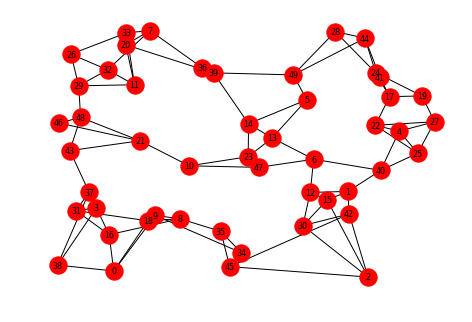

In [121]:
plot_g(G)